In [5]:
# --- Librerie Standard e Utilità ---
import os
import json
import random
import numpy as np
from tqdm import tqdm

# --- Machine Learning e Processamento Dati ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# --- Ottimizzazione e Monitoraggio ---
import optuna
import wandb

# --- Moduli Personalizzati ---
from training_utils import *
from testing_utils import *
from plotting_utils import *

In [6]:
csvs = ['./remote_results/final_results/THR001.csv',
        './remote_results/final_results/THR025.csv',
        './remote_results/final_results/THR050.csv',
        './remote_results/final_results/THR070.csv',
        './remote_results/final_results/THR075.csv',
        './remote_results/final_results/THR080.csv',
        './remote_results/final_results/THR085.csv',
        './remote_results/final_results/THR090.csv',
        './remote_results/final_results/THR095.csv',
        './remote_results/final_results/THR099.csv']
csvs2 = ['./remote_results/final_results/THR101.csv',
        './remote_results/final_results/THR125.csv',
        './remote_results/final_results/THR150.csv',
        './remote_results/final_results/THR170.csv',
        './remote_results/final_results/THR175.csv',
        './remote_results/final_results/THR180.csv',
        './remote_results/final_results/THR185.csv',
        './remote_results/final_results/THR190.csv',
        './remote_results/final_results/THR195.csv',
        './remote_results/final_results/THR199.csv']

In [7]:
cols = ['success', 'collisions', 'reward', 'lenght', 'distance_traveled', 'path_length_ratio', 'SPL', 'cbf_time', 'uf_time', 'policy_time', 'unity_time',   'seed']

--- Inizio elaborazione ---


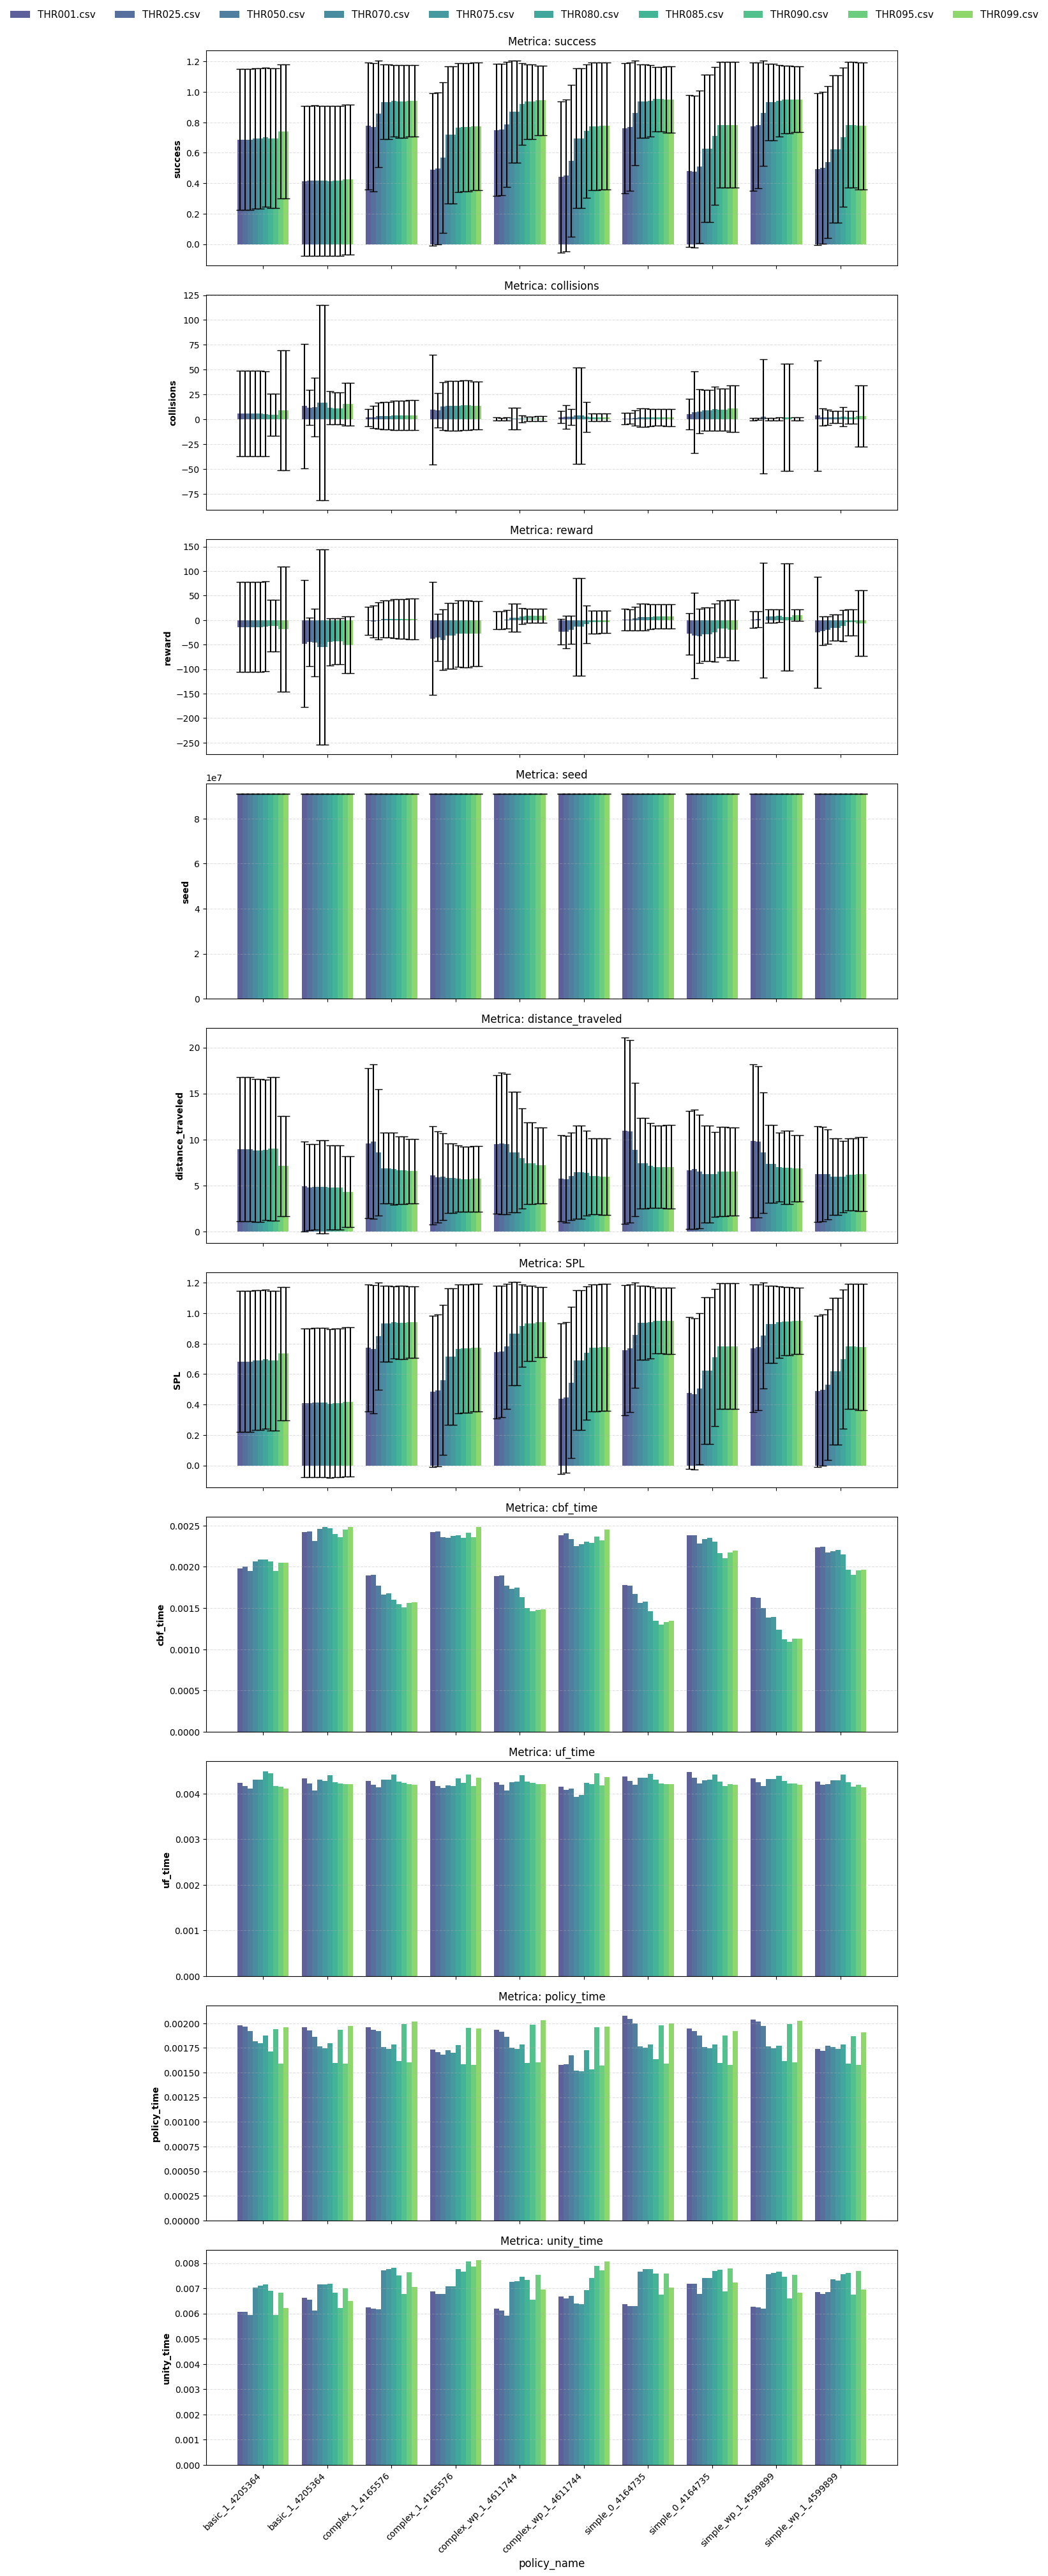

In [8]:
plotta_confronto_csv_final(csvs, 0, 'policy_name', cols)

--- Inizio elaborazione ---


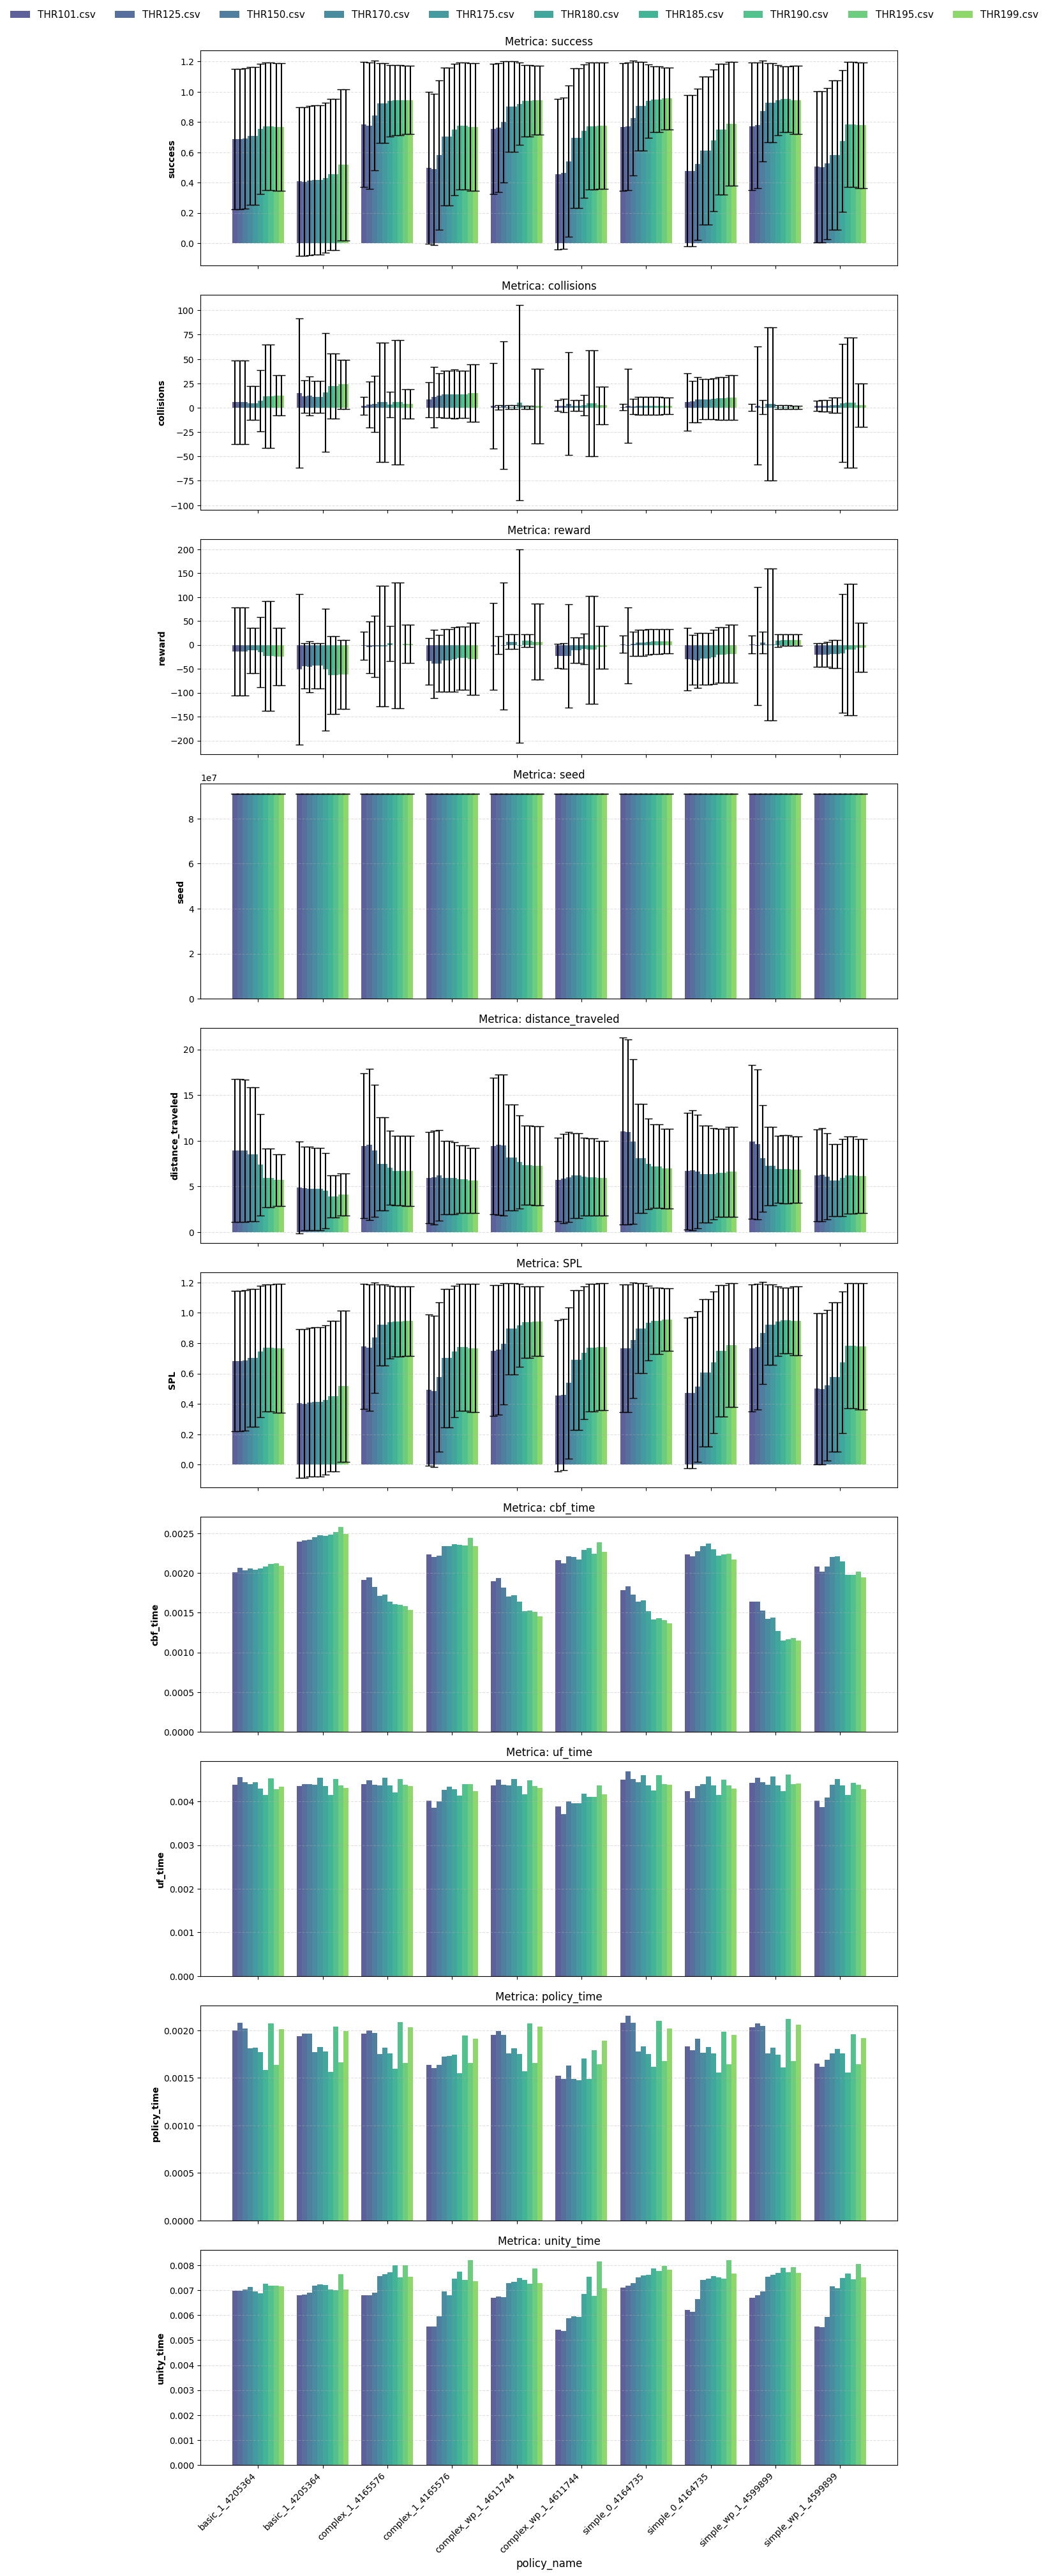

In [9]:
plotta_confronto_csv_final(csvs2, 0, 'policy_name', cols)

In [1]:
import pandas as pd
import json
import math
import matplotlib.pyplot as plt
import numpy as np

def multy_plot_visualfiltered(csv_list, m1, m2, ncols=2, filter=lambda x: True, remove_outlier=2):
    data_liste = []
    metriche_liste = []
    labels = []

    # Lista delle policy da analizzare
    policies = ['basic_1_4205364', 'simple_0_4164735', 'simple_wp_1_4599899', 'complex_1_4165576', 'complex_wp_1_4611744']
    
    for p in policies:
        raw_data = {}
        th_list = [0.01, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
        for env in ['obstacles_simple', 'obstacles_complex']:
            
            for i, th_path in enumerate(csv_list):
                # 1. Caricamento dati
                control_df = pd.read_csv(th_path)
                control_row = control_df.query(f"policy_name == '{p}' and env_name == '{env}'")
                
                if control_row.empty:
                    continue
                    
                specific_test_name = control_row['test_name'].values[0]
                json_path = th_path.rsplit('/', 1)[0] + '/' + specific_test_name + '_info.json'
                
                with open(json_path, 'r') as f:
                    specific_test_data = json.load(f)
                
                # 2. Elaborazione e calcolo metriche personalizzate
                current_episodes = []
                for ep in specific_test_data['data']:
                    if filter(ep):
                        # Calcolo metriche aggiuntive
                        ep_ext = ep.copy()
                        ep_ext['velocity'] = ep['distance_traveled'] / ep['length'] if ep['length'] > 0 else 0
                        ep_ext['weighted_success'] = ep['success'] * ep['path_tortuosity']
                        ep_ext['SPL'] = ep['success'] * (ep['path_length'] / max(ep['distance_traveled'], ep['path_length']))
                        ep_ext['SPL2'] = ep['success'] * (ep['path_length'] / ep['distance_traveled']) if ep['distance_traveled'] > 0 else 0
                        current_episodes.append(ep_ext)

                # 3. RIMOZIONE OUTLIERS
                # Rimuoviamo i 2 minimi e 2 massimi basandoci su m1 e poi su m2
                # Lo facciamo solo se abbiamo abbastanza dati (almeno 5 per lasciare qualcosa)

                # 4. Aggregazione nel dizionario raw_data
                if th_list[i] in raw_data:
                    raw_data[th_list[i]].extend(current_episodes)
                else:
                    raw_data[th_list[i]] = current_episodes

        def get_outlier_indices(episodes, metric, n=2):
            """Restituisce gli indici dei n valori più piccoli e n più grandi."""
            if len(episodes) <= n * 2:
                return set()
            
            # Creiamo una lista di tuple (valore, indice_originale)
            indexed_values = [(ep.get(metric, 0), i) for i, ep in enumerate(episodes)]
            indexed_values.sort(key=lambda x: x[0])
            
            # Prendiamo gli indici dei primi n e degli ultimi n
            low_indices = {idx for val, idx in indexed_values[:n]}
            high_indices = {idx for val, idx in indexed_values[-n:]}
            
            return low_indices | high_indices

        # --- All'interno della tua funzione, dopo aver accumulato tutti gli episodi ---

        for th, episodes in raw_data.items():
            if len(episodes) > remove_outlier*4:
                # 1. Identifichiamo gli indici degli outliers per m1, m2 (e m3 se vuoi)
                outliers_to_remove = set()
                outliers_to_remove |= get_outlier_indices(episodes, m1, n=remove_outlier)
                outliers_to_remove |= get_outlier_indices(episodes, m2, n=remove_outlier)
                # Se avessi una terza metrica SPL:
                # outliers_to_remove |= get_outlier_indices(episodes, 'SPL', n=2)

                # 2. Creiamo la lista filtrata escludendo quegli indici
                # Usiamo list comprehension per efficienza
                cleaned_episodes = [
                    ep for i, ep in enumerate(episodes) 
                    if i not in outliers_to_remove
                ]
                
                raw_data[th] = cleaned_episodes
            else:
                raw_data[th] = episodes
                        
        data_liste.append([raw_data])
        metriche_liste.append((m1, m2))
        labels.append([p])

    # --- Parte di Visualizzazione ---
    nrows = math.ceil(len(data_liste) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    axes_flat = np.atleast_1d(axes).flatten()

    for i in range(len(data_liste)):
        if i < len(axes_flat):
            plot_metric_series_on_ax(
                ax=axes_flat[i],
                data_list_x=data_liste[i],
                data_list_y=data_liste[i],
                metric_x=metriche_liste[i][0],
                metric_y=metriche_liste[i][1],
                labels=labels[i]
            )
            # Stampa di debug per vedere quanti episodi restano dopo la pulizia
            key_debug = 0.01
            count = len(data_liste[i][0][key_debug]) if key_debug in data_liste[i][0] else 0
            print(f'Episodi restanti per {labels[i]}: {count}')

    plt.tight_layout()
    plt.show()

In [11]:
import numpy as np
from collections import defaultdict

def calculate_stats_from_list(data_list, percentiles=[1] + list(range(0,100,5)) + [99]):
    """
    Calcola statistiche robuste gestendo anche Booleani e NaN.
    """
    grouped_values = defaultdict(list)
    
    # 1. Raccogliamo i dati puliti
    for entry in data_list:
        if not isinstance(entry, dict):
            continue
            
        for key, value in entry.items():
            # Nota: bool è sottoclasse di int in Python, quindi passa questo check.
            # Accettiamo bool, int, float, numpy types
            if isinstance(value, (int, float, bool, np.number)):
                # Escludiamo NaN se è un float, ma lasciamo passare i bool
                if isinstance(value, float) and np.isnan(value):
                    continue
                grouped_values[key].append(value)

    stats_results = {}
    
    # 2. Calcoliamo le statistiche
    for key, values in grouped_values.items():
        if not values:
            continue
            
        # Creiamo l'array numpy
        arr = np.array(values)
        
        # --- FIX PER L'ERRORE ---
        # Se l'array è di tipo booleano, lo convertiamo in float (0.0 e 1.0)
        # Questo permette di calcolare media (tasso successo) e percentili senza errori.
        if arr.dtype == bool:
            arr = arr.astype(float)
        # ------------------------
        
        # Calcolo statistiche base
        key_stats = {
            "mean": np.mean(arr),
            "std": np.std(arr),
            "min": np.min(arr),
            "max": np.max(arr),
            "count": len(arr)
        }
        
        # Calcolo percentili
        for p in percentiles:
            # np.percentile vuole valori 0-100
            key_stats[f"p{p}"] = np.percentile(arr, p)
            
        stats_results[key] = key_stats
        
    return stats_results

In [ ]:
pd.DataFrame(calculate_stats_from_list(raw_data[0.01]))

,id,success,collisions,reward,length,seed,distance_traveled,global_avg_dist_obstacle,global_avg_visibility,global_avg_dispersion,global_characteristic_dimension,path_tortuosity,path_length
mean,3.971000,0.45600,2.112000,-23.546285,1435.592000,9.090270e+07,5.753424,2.337157,6.359657,4.695256,6.504319,1.260346,21.474610
std,2.555809,0.49806,5.446233,25.158243,722.603991,2.886750e+02,4.583220,0.205107,0.945439,0.794901,0.881819,0.467721,13.387368
min,0.000000,0.00000,0.000000,-199.878311,36.000000,9.090220e+07,0.000009,1.600000,2.220000,0.983042,2.560000,1.000000,1.599999
max,8.000000,1.00000,78.000000,16.254805,1999.000000,9.090320e+07,40.066067,3.317320,9.578257,7.121855,10.632555,5.334186,73.418243
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
p1,0.000000,0.00000,0.000000,-87.935807,54.000000,9.090221e+07,0.174910,1.865634,3.908622,2.505978,4.449500,1.000000,1.600000
p0,0.000000,0.00000,0.000000,-199.878311,36.000000,9.090220e+07,0.000009,1.600000,2.220000,0.983042,2.560000,1.000000,1.599999
p5,0.000000,0.00000,0.000000,-57.970542,121.950000,9.090225e+07,0.544611,2.024606,4.924108,3.457761,5.175786,1.000000,3.200001
p10,0.000000,0.00000,0.000000,-48.887325,232.900000,9.090230e+07,1.139656,2.103853,5.268909,3.786315,5.504153,1.000000,5.768882
p15,1.000000,0.00000,0.000000,-43.884328,386.700000,9.090235e+07,1.593480,2.140684,5.481383,3.940114,5.676170,1.000000,7.062742


Episodi restanti per ['basic_1_4205364'] (th 0.01): 1992
Episodi restanti per ['simple_0_4164735'] (th 0.01): 1992
Episodi restanti per ['simple_wp_1_4599899'] (th 0.01): 1992
Episodi restanti per ['complex_1_4165576'] (th 0.01): 1992
Episodi restanti per ['complex_wp_1_4611744'] (th 0.01): 1992


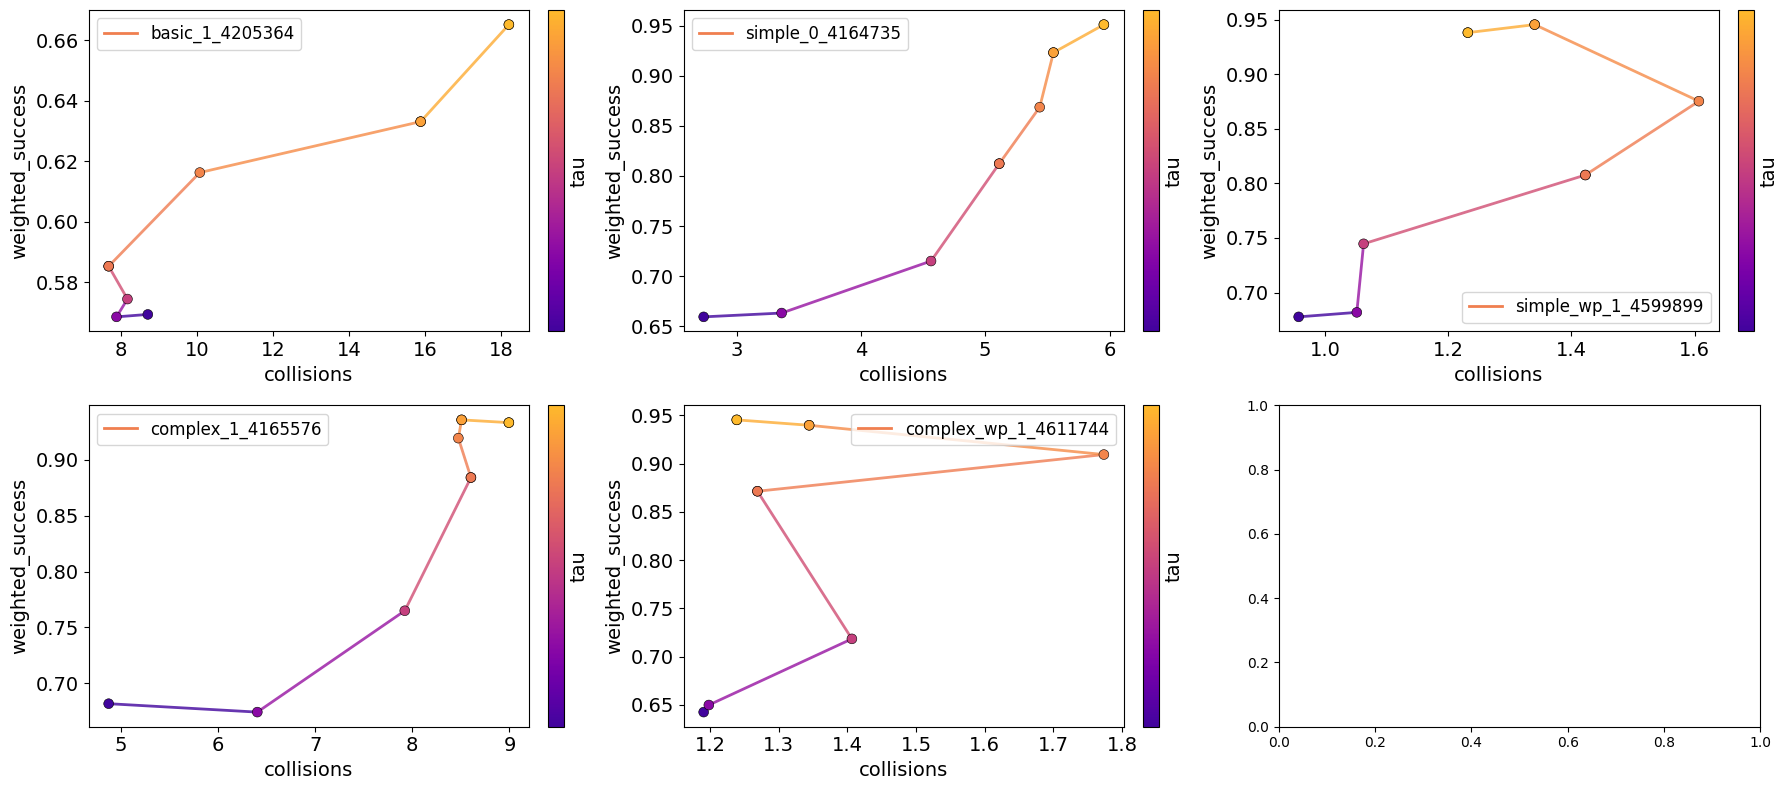

In [69]:
multy_plot_visualfiltered(csvs2, 'collisions', 'weighted_success', 3) #, lambda x: ( x['path_tortuosity'] > 1.2))

Episodi restanti per ['basic_1_4205364'] (th 0.01): 1996
Episodi restanti per ['simple_0_4164735'] (th 0.01): 1996
Episodi restanti per ['simple_wp_1_4599899'] (th 0.01): 1996
Episodi restanti per ['complex_1_4165576'] (th 0.01): 1996
Episodi restanti per ['complex_wp_1_4611744'] (th 0.01): 1996


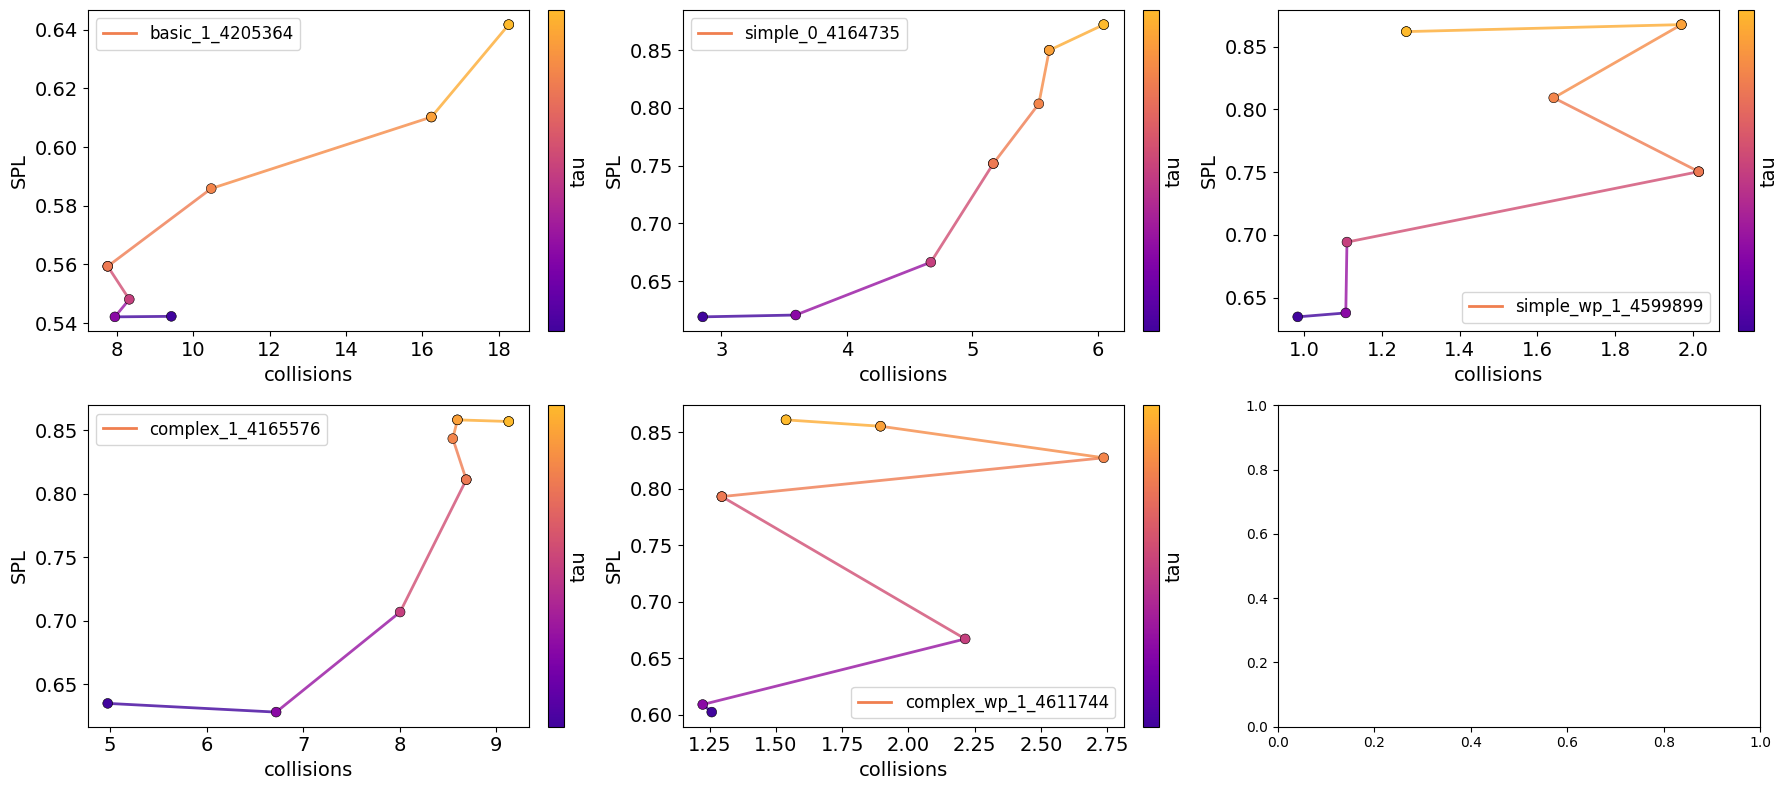

In [68]:
multy_plot_visualfiltered(csvs2, 'collisions', 'SPL', 3, remove_outlier=1) #, lambda x: ( x['path_tortuosity'] > 1.2))